In [1]:
# from pandas_datareader import data
from pandas_datareader import data, wb
# import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf


from pypfopt import risk_models
from pypfopt import plotting

from pypfopt.expected_returns import mean_historical_return
# from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

In [2]:
def download_prices(tickers, start_date, end_date):
    '''
    Download stick prices from yahoo finance.
    '''

    df = yf.download(tickers, start=start_date, end=end_date)

    # Get just close price
    df_close = df["Adj Close"]

    # check if everything is ok
    if(df_close.empty==False):
        return df_close
    else:
        print("Error")

In [3]:
def download_mcaps(tickers, start_analysis_date, end_analysis_date):
    '''
    Download mcap price of each stock.
    '''

    # create an empty dicitionary
    mcaps = {}

    for t in tickers:
        
        # Download historical prices
        df = yf.download(t, start=start_analysis_date, end=end_analysis_date)

        # get the price of the day that I am creating the portfolio
        price = df.loc[df.index==start_analysis_date, 'Close'][0]

        # create an object
        stock = yf.Ticker(t)

        # get mcap from yahoo
        sharesOutstanding = stock.info['sharesOutstanding']

        # Get the market captalization of the company
        mcap = sharesOutstanding * price

        # Add value in the dictionary
        mcaps[t] = mcap
    
    return mcaps

In [4]:
def plot_stock_prices(df):

  df.plot(figsize=(15,10))

  # Show the legend
  plt.legend()

  # Define the label for the title of the figure
  plt.title("Preço das Ações 01/01/2015 - 31/12/2018", fontsize=16)

  # Define the labels for x-axis and y-axis
  plt.ylabel('Preço (R$)', fontsize=14)
  plt.xlabel('Data', fontsize=14, rotation=0)
  plt.xticks(rotation=0, ha='center')

  # Plot the grid lines
  plt.grid(which="major", color='w', linestyle='-.', linewidth=0.5)
  plt.show()

In [5]:
def create_output_dataframe(tickers):

  # Create empty dataframe
  df = pd.DataFrame(columns=['Stock'])

  # Put the nada of stocks
  df['Stock'] = tickers
  
  return df

In [6]:
def plot_correlations(df_sample, df_shrinkage):
    '''
    Plot correlation heatmap.
    '''

    plotting.plot_covariance(df_sample, plot_correlation=True)
    plotting.plot_covariance(df_shrinkage, plot_correlation=True)

In [7]:
def join_dataframe(result_list, df, method_name):

  # Convet input in dataframe
  result_df = pd.DataFrame(list(result_list.items()))

  column_name = 'Weight ' + method_name

  result_df = result_df.rename(columns={0: 'Stock', 1: column_name})

  # Merge results
  df = df.merge(result_df, on=['Stock'])


  return df

In [8]:
def optmizer_max_sharpe(mu, cov_matrix, risk_free_rate, df_output):
    '''Maximise the Sharpe Ratio. The result is also referred to as the tangency 
    portfolio, as it is the portfolio for which the capital market line is tangent 
    to the efficient frontier.'''

    # # Define the risk free rate
    # risk_free_rate = 0.3

    # Calculate the efficient Frontier
    ef = EfficientFrontier(mu, cov_matrix)
    weights_max_sharpe = ef.max_sharpe(risk_free_rate)


    # Auxiliar to visualize weights better
    cleaned_weights_max_sharpe = ef.clean_weights()

    # # Show values
    # print('------------------- Max Sharpe Optimizer -------------------------------------\n')

    # display(cleaned_weights_max_sharpe)

    # expected performance of the portfolio with optimal weights
    # ef.portfolio_performance(verbose=True)

    df_output = join_dataframe(cleaned_weights_max_sharpe, df_output, 'Max Sharpe')

    return df_output

In [9]:
def optmizer_min_volatility(mu, cov_matrix, df_output):
    '''Minimise volatility'''

    # Calculate the efficient Frontier
    ef = EfficientFrontier(mu, cov_matrix)
    weights_min_volatility = ef.min_volatility()

    # Auxiliar to visualize weights better
    cleaned_weights_min_volatility = ef.clean_weights()

    # # Show values
    # print('\n\n------------------- Min Volatility Optimizer ---------------------------------\n')

    # display(cleaned_weights_min_volatility)

    # expected performance of the portfolio with optimal weights
    # ef.portfolio_performance(verbose=True)

    df_output = join_dataframe(cleaned_weights_min_volatility, df_output, 'Min Volatility')

    return df_output

In [10]:
def optmizer_max_quadratic(mu, cov_matrix, df_output):
    '''Maximise the given quadratic utility'''

    # Calculate the efficient Frontier
    ef = EfficientFrontier(mu, cov_matrix)
    
    weights_max_quadratic_utility = ef.max_quadratic_utility(risk_aversion=1, 
                                                            market_neutral=False)

    # Auxiliar to visualize weights better
    cleaned_weights_max_quadratic_utility = ef.clean_weights()

    # # Show values
    # print('\n\n------------------- Max Quadratic Utility Optimizer --------------------------\n')

    # display(cleaned_weights_max_quadratic_utility)

    # expected performance of the portfolio with optimal weights
    # ef.portfolio_performance(verbose=True)

    df_output = join_dataframe(cleaned_weights_max_quadratic_utility, df_output, 'Max Quadratic')

    return df_output

In [11]:
def optmizer_risk_optmizer(mu, cov_matrix, df_output, target_volatility):
    '''Maximise return for a target risk. The resulting portfolio will have a 
    volatility less than the target (but not guaranteed to be equal).'''

    # Calculate the efficient Frontier
    ef = EfficientFrontier(mu, cov_matrix)
    weights_risk_optimizer = ef.efficient_risk(target_volatility, 
                                                      market_neutral=False)

    # Auxiliar to visualize weights better
    cleaned_weights_risk_optimizer = ef.clean_weights()

    # # Show values
    # print('\n\n------------------- Efficient Risk Optimizer ---------------------------------\n')

    # display(cleaned_weights_risk_optimizer)

    # expected performance of the portfolio with optimal weights
    # ef.portfolio_performance(verbose=True)

    column_name = 'Risk ' + str(target_volatility*100) + '%'

    df_output = join_dataframe(cleaned_weights_risk_optimizer, df_output, column_name)

    return df_output

In [12]:
def optmizer_return_optmizer(mu, cov_matrix, df_output, target_return):
    '''Calculate the ‘Markowitz portfolio’, minimising volatility for a given target
    return.'''

    # Calculate the efficient Frontier
    ef = EfficientFrontier(mu, cov_matrix)
    weights_efficient_return_optimizer = ef.efficient_return(target_return, 
                                                        market_neutral=False)

    # Auxiliar to visualize weights better
    cleaned_weights_efficient_return_optimizer = ef.clean_weights()

    # # Show values
    # print('\n\n------------------- Efficient Return Optimizer -------------------------------\n')

    # display(cleaned_weights_efficient_return_optimizer)

    # expected performance of the portfolio with optimal weights
    # ef.portfolio_performance(verbose=True)

    column_name = 'Return ' + str(target_return*100) + '%'

    df_output = join_dataframe(cleaned_weights_efficient_return_optimizer, df_output, column_name)

    return df_output

In [13]:
def optimizers(mu, cov_matrix, df_output):

    # ------------------------------------------------------------------------------
    # ------------------- Max Sharpe Optimizer -------------------------------------
    # ------------------------------------------------------------------------------

    # Define the risk free rate
    risk_free_rate = 0.03

    df_output = optmizer_max_sharpe(mu, cov_matrix, risk_free_rate, df_output)

    # ------------------------------------------------------------------------------
    # ------------------- Min Volatility Optimizer ---------------------------------
    # ------------------------------------------------------------------------------

    df_output = optmizer_min_volatility(mu, cov_matrix, df_output)

    # ------------------------------------------------------------------------------
    # ------------------- Max Quadratic Utility Optimizer --------------------------
    # ------------------------------------------------------------------------------

    df_output = optmizer_max_quadratic(mu, cov_matrix, df_output)

    # ------------------------------------------------------------------------------
    # ------------------- Efficient Risk Optimizer ---------------------------------
    # ------------------------------------------------------------------------------

    # The desired maximum volatility of the resulting portfolio
    target_volatility = 0.25

    df_output = optmizer_risk_optmizer(mu, cov_matrix, df_output, target_volatility)

    # ------------------------------------------------------------------------------
    # ------------------- Efficient Return Optimizer -------------------------------
    # ------------------------------------------------------------------------------

    # The desired return of the resulting portfolio
    target_return = 0.1

    df_output = optmizer_return_optmizer(mu, cov_matrix, df_output, target_return)

    return df_output

In [14]:
def create_omega(tickers, viewdict):

    variances = []

    for each_ticker in tickers:
        middle_range = viewdict[each_ticker]

        lb = middle_range * 0.8
        ub = middle_range * 1.2

        sigma = (ub - lb)/2
        variances.append(sigma ** 2)

    omega = np.diag(variances)

    return omega

In [15]:
def get_market_views(tickers):
    start_date = '2019-10-31'
    end_date = '2019-11-01'

    # Download prices
    df_price_out_19 = download_prices(tickers, start_date, end_date)

    # Create a column with XP views
    view_xp = [60, 58, 65, 27, 45, 37, 58]

    # Append prices in dataframe
    df_length = len(df_price_out_19)
    df_price_out_19.loc[df_length] = view_xp

    # Get the percentage change and convert to dictionary
    df_var = df_price_out_19.pct_change().iloc[1].to_dict()

    return df_var

In [16]:
tickers = ['AZUL4.SA', 'BTOW3.SA', 'CPLE6.SA', 'ENBR3.SA' , 'BBDC4.SA', 'JBSS3.SA', 'IGTA3.SA']

start_date = '2013-01-01'
end_date = '2017-12-31'

df = download_prices(tickers, start_date, end_date)

start_analysis_date = "2018-01-02"
end_analysis_date = "2018-01-03"

mcaps = download_mcaps(tickers, start_analysis_date, end_analysis_date)

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


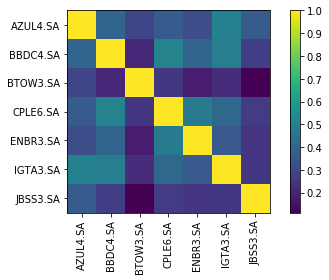

,Stock,Weight Max Sharpe,Weight Min Volatility,Weight Max Quadratic,Weight Risk 25.0%,Weight Return 10.0%
0,AZUL4.SA,0.88441,0.11911,1.0,0.38608,0.11911
1,BTOW3.SA,0.00000,0.04140,0.0,0.00246,0.04140
2,CPLE6.SA,0.00000,0.01043,0.0,0.00000,0.01043
3,ENBR3.SA,0.00000,0.28960,0.0,0.21147,0.28960
4,BBDC4.SA,0.11559,0.13360,0.0,0.19394,0.13360
5,JBSS3.SA,0.00000,0.05601,0.0,0.02208,0.05601
6,IGTA3.SA,0.00000,0.34985,0.0,0.18397,0.34985


In [17]:
# Calculate Covariance
# sample_cov, shrinkage_cov = get_covariance_matrix(df)

sample_cov = risk_models.sample_cov(df, frequency=252)

# Show covariance figure
plotting.plot_covariance(sample_cov, plot_correlation=True)

# estimating expected returns
mu = mean_historical_return(df)

# --------------------------------------------------------------------------------------
# ----------------------- Using sample covariance --------------------------------------
# --------------------------------------------------------------------------------------

# create output dataframe to organize the results
df_output = create_output_dataframe(tickers)

# get all the results
df_markowitz_sample = optimizers(mu, sample_cov, df_output)

display(df_markowitz_sample)

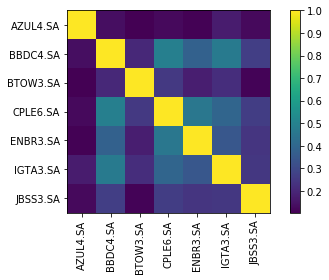

,Stock,Weight Max Sharpe,Weight Min Volatility,Weight Max Quadratic,Weight Risk 25.0%,Weight Return 10.0%
0,AZUL4.SA,0.96754,0.77029,1.0,1.0,0.77029
1,BTOW3.SA,0.00000,0.00750,0.0,0.0,0.00750
2,CPLE6.SA,0.00000,0.00224,0.0,0.0,0.00224
3,ENBR3.SA,0.00000,0.08890,0.0,0.0,0.08890
4,BBDC4.SA,0.03246,0.03754,0.0,0.0,0.03754
5,JBSS3.SA,0.00000,0.00900,0.0,0.0,0.00900
6,IGTA3.SA,0.00000,0.08452,0.0,0.0,0.08452


In [18]:
# Calculate Covariance
shrinkage_cov = risk_models.CovarianceShrinkage(df).ledoit_wolf()

# Show correlation figure
plotting.plot_covariance(shrinkage_cov, plot_correlation=True)

# estimating expected returns
mu = mean_historical_return(df)

# --------------------------------------------------------------------------------------
# ----------------------- Using ledoit wolf covariance ---------------------------------
# --------------------------------------------------------------------------------------

# get all the results
df_markowitz_shrinkage = optimizers(mu, shrinkage_cov, df_output)

# create output dataframe to organize the results
df_output = create_output_dataframe(tickers)

display(df_markowitz_shrinkage)

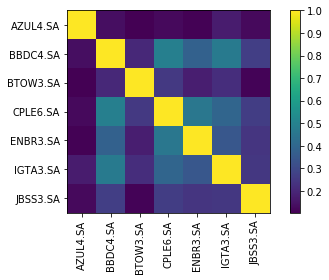

[*********************100%***********************]  7 of 7 completed


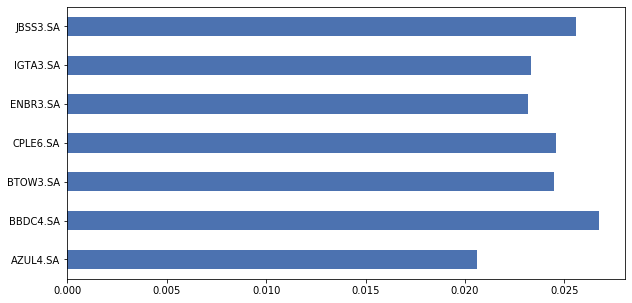

In [19]:
# --------------------------------------------------------------------------------------
# ----------------------- Get covariance -----------------------------------------------
# --------------------------------------------------------------------------------------

# Calculate Covariance
shrinkage_cov = risk_models.CovarianceShrinkage(df).ledoit_wolf()

# Show correlation figure
plotting.plot_covariance(shrinkage_cov, plot_correlation=True)

# --------------------------------------------------------------------------------------
# ----------------------- Calculate expected return ------------------------------------
# --------------------------------------------------------------------------------------

# Calculate delta
delta = black_litterman.market_implied_risk_aversion(pd.Series(mcaps))

# Expected return
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, shrinkage_cov)

# Plot market prior values
market_prior.plot.barh(figsize=(10,5))

# --------------------------------------------------------------------------------------
# ----------------------- Market Views -------------------------------------------------
# --------------------------------------------------------------------------------------

# Get market views
viewdict = get_market_views(tickers)

# --------------------------------------------------------------------------------------
# ----------------------- Confidence Matrix --------------------------------------------
# --------------------------------------------------------------------------------------

# confidences = [
#     0.6,
#     0.6,
#     0.6,
#     0.6,
#     0.6, 
#     0.6, 
#     0.5,
# ]

In [20]:

confidences = [
    0.7,
    0.7,
    0.7,
    0.7,
    0.7, 
    0.7, 
    0.7,
]

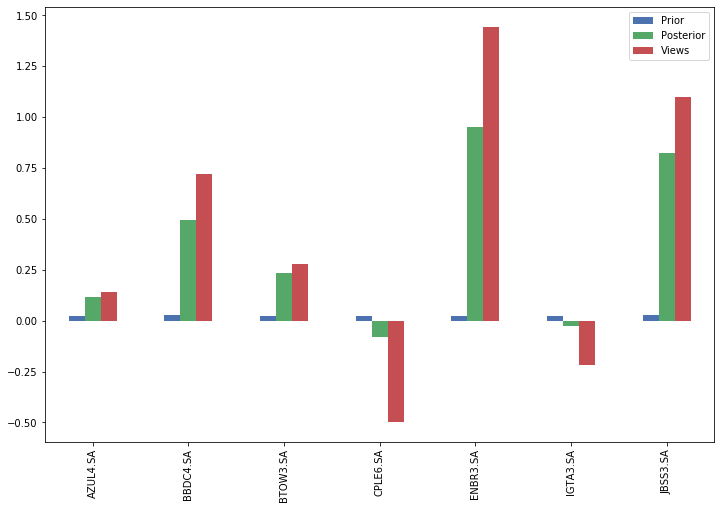

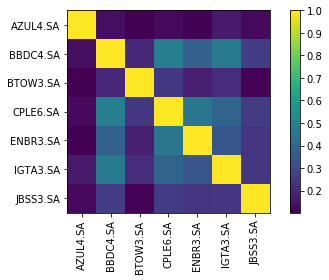

,Stock,Weight Max Sharpe,Weight Min Volatility,Weight Max Quadratic,Weight Risk 25.0%,Weight Return 10.0%
0,AZUL4.SA,0.10185,0.76825,0.0,0.16883,0.76825
1,BTOW3.SA,0.00000,0.00771,0.0,0.00000,0.00771
2,CPLE6.SA,0.00000,0.00294,0.0,0.00000,0.00294
3,ENBR3.SA,0.70839,0.08884,1.0,0.65137,0.08884
4,BBDC4.SA,0.03444,0.03801,0.0,0.03780,0.03801
5,JBSS3.SA,0.15532,0.00934,0.0,0.14200,0.00934
6,IGTA3.SA,0.00000,0.08491,0.0,0.00000,0.08491


In [21]:


# Calculate Black Litterman Model
bl = BlackLittermanModel(shrinkage_cov, pi=market_prior, market_caps=mcaps, risk_averison=delta, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

# Posterior estimate of returns
ret_bl = bl.bl_returns()

# compare three different views
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], index=["Prior", "Posterior", "Views"]).T
rets_df.plot.bar(figsize=(12,8))

# Calculate the posterior estimate of the covariance matrix, given views on some assets. 
# Based on He and Litterman (2002). It is assumed that omega is diagonal.
S_bl = bl.bl_cov()

# Show correlation figure
plotting.plot_covariance(S_bl, plot_correlation=True)

# create output dataframe to organize the results
df_output = create_output_dataframe(tickers)

optimizers(ret_bl, S_bl, df_output)